# Sensordata fra Garmin løpeklokke

Datasettet `garmindata.csv` har vi lastet ned fra en personlig brukerkonto på connect.garmin.com. Datasettet består av sensormålinger fra 56 løpeturer, f.eks. tid, avstand, høydemeter, stegfreksens og puls. I tillegg regner løpeklokkens programvare ut andre størrelser slik som estimert kaloriforbuk. Vi er hovedsakelig interresert i sammenhengen mellom *tid og distanse*. 

## Læringsmål: Korrelasjon og minste kvadratsums rette linje (regresjonslinje)

### Delmål
1. Laste inn og behandle et komplekst datasett
2. Plotte kryssplott, identifisere og håndtere uteliggere
3. Regne ut korrelasjon og regresjonslinje

*Hva er relevant for tellende vurdering? Erfaringen med å håndtere datasett i Python får du nytte av i den tellende prosjektoppgaven, og i resten av utdanningen din. Du skal ikke skrive kode selv på eksamen, men du må kunne lese, tolke og forklare utskrift og plott fra ulike statistikk-beregninger i Python.*

## Steg 1: Laste inn nødvendige python-pakker

In [1]:
import pandas as pd # lese data fra csv-fil og bruke DataFrames
import seaborn as sns # plotting
sns.set(style = 'whitegrid', font_scale = 1.5) # utseende av plott
import matplotlib.pyplot as plt # mer plotting
import numpy as np # matematikk
import statsmodels.api as sms # regresjonen
import statsmodels.formula.api as smf # formel for regresjonen

## Steg 2: Lese inn og behandle data

In [2]:
df = pd.read_csv('https://www.math.ntnu.no/emner/IST100x/python_felles/garmindata.csv')
df.shape # dimenensjonen til datasettet

(56, 30)

In [3]:
print(df.columns) # Alle kolonnenavn

Index(['Activity.Type', 'Date', 'Favorite', 'Title', 'Distance', 'Calories',
       'Time', 'Avg.HR', 'Max.HR', 'Aerobic.TE', 'Avg.Run.Cadence',
       'Max.Run.Cadence', 'Avg.Pace', 'Best.Pace', 'Elev.Gain', 'Elev.Loss',
       'Avg.Stride.Length', 'Avg.Vertical.Ratio', 'Avg.Vertical.Oscillation',
       'Training.Stress.Score.', 'Grit', 'Flow', 'Climb.Time', 'Bottom.Time',
       'Min.Temp', 'Surface.Interval', 'Decompression', 'Best.Lap.Time',
       'Number.of.Laps', 'Max.Temp'],
      dtype='object')


In [4]:
# Merk at en del kolonnenavn inneholder punktum
# Dette er generelt uheldig når vi programmerer, så vi 
# erstatter alle punktum med underscore

df.columns = df.columns.str.replace("[.]", "_")

/tmp/ipykernel_34024/1926521589.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("[.]", "_")


In [5]:
df.head() # ser på de 5 første linjene i datasettet

,Activity_Type,Date,Favorite,Title,Distance,Calories,Time,Avg_HR,Max_HR,Aerobic_TE,...,Grit,Flow,Climb_Time,Bottom_Time,Min_Temp,Surface_Interval,Decompression,Best_Lap_Time,Number_of_Laps,Max_Temp
0,Running,2020-10-01 15:47:25,False,Trondheim Running,6.10,381,00:37:16,159,178,3.3,...,0,0,37:16,0:00,17,0:00,No,00:35.70,7,0
1,Running,2020-09-29 15:17:10,False,Trondheim Running,5.27,343,00:30:47,170,182,3.6,...,0,0,30:47,0:00,17,0:00,No,01:33.11,6,0
2,Running,2020-09-28 15:58:24,False,Trondheim Running,4.03,282,00:27:54,155,190,3.0,...,0,0,27:54,0:00,19,0:00,No,00:16.79,5,0
3,Running,2020-09-28 08:02:20,False,Trondheim Running,4.01,253,00:24:16,160,182,3.1,...,0,0,24:16,0:00,16,0:00,No,00:02.10,5,0
4,Running,2020-09-23 15:36:44,False,Trondheim Running,4.33,299,00:29:25,159,188,3.2,...,0,0,29:25,0:00,20,0:00,No,02:19.23,5,0


Merk at kolonnen 'Time' inneholder tid på formatet timer:minutter:sekunder. Dette må vi kode om til desimaltall, og det mest naturlige er å bruke minutter som enhet. 

In [6]:
# Vi lager oss en funksjon som koder fra timer:minutter:sekunder til minutter

def get_min(time_str):
    h, m, s = time_str.split(':')
    return round(int(h)*60 + int(m) + int(s)/60 , 2)

# Lager en TimeMin kolonne i datasettet
df['TimeMin'] = df['Time'].apply(get_min)

## Steg 2: Kryssplott og kvalitetskontroll

Tabellen vi har lastet inn er for stor til at vi klarer å kvalitetssjekke observasjoner og få et inntrykk av dataene. Siden vi hovedsakelig er interessert i sammenhengen mellom *tid og distanse* plotter vi et kryssplott av disse observasjonene. 

Text(0.5, 21.444444444444443, 'Distanse [km]')

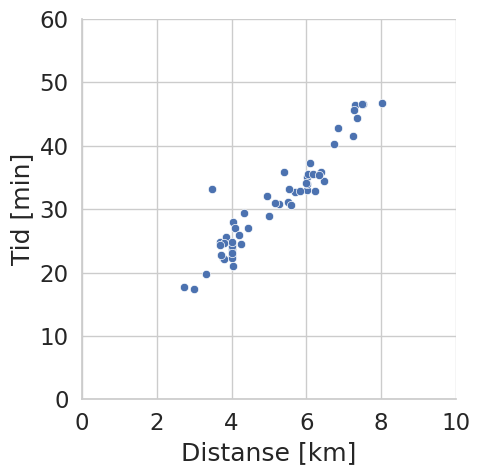

In [7]:
# Plotter tid mot distanse for å få et intrykk av datasettet

sns.relplot(x='Distance', y='TimeMin',data = df)
plt.xlim(0,10); plt.ylim(0,60)

plt.ylabel('Tid [min]'); plt.xlabel('Distanse [km]')

# Vi identifiserer en "rar" observasjon:
# En løpetur på under 4 km som tok over 30 minutter!
# Kanskje er dette en gåtur som har blit feilregistrert?

<Axes: ylabel='Hastighet'>

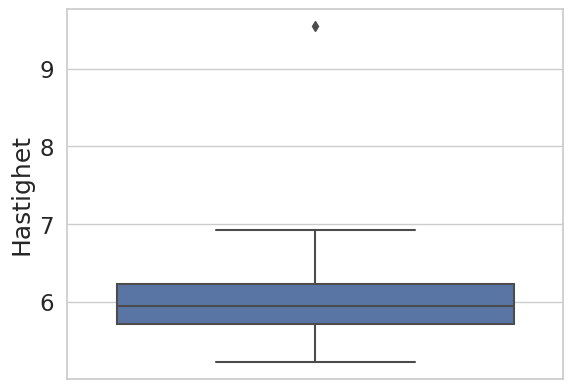

In [8]:
# Vi ser på observasjonene av gjennomsnittshastighet, Avg.Pace
# tips: print(df.columns) kan brukes for å se på alle kolonnetitlene
# Merk: Avg.Pace er skrevet i min:sek per kilometer
# Vi lager oss derfor en ny kolonne med minutter som desimaltall
def get_min2(time_str):
    m, s = time_str.split(':')
    return round(int(m) + int(s)/60 , 2)

df['Hastighet'] = df['Avg_Pace'].apply(get_min2)

# Plotter boksplott over hastighet
sns.boxplot(y = 'Hastighet', data = df)

# Her ser vi en klar uteligger! 
# En hastighet (min/km) på voer 9 minutter per kilometer betyr at dette var en 
# gåtur og hører ikke hjemme i løpe-tur datasettet

In [9]:
np.argmax(df['Hastighet']) # Hvilken index har uteliggeren?

21

Text(0.5, 21.444444444444443, 'Distanse [km]')

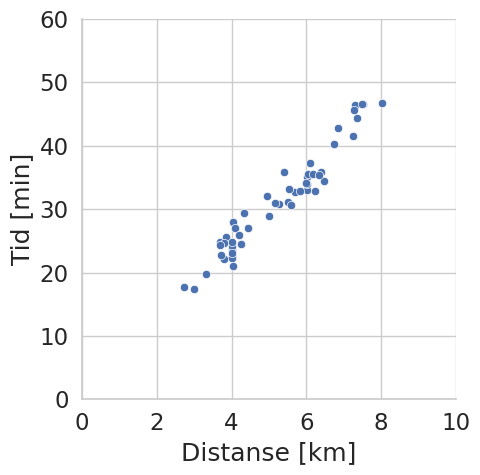

In [10]:
# Fjerner uteligger fra datasettet og lager det samme kryssplottet som før
dfny = df.drop(21)
sns.relplot(x='Distance', y='TimeMin',data = dfny)
plt.xlim(0,10); plt.ylim(0,60)
plt.ylabel('Tid [min]'); plt.xlabel('Distanse [km]')

In [11]:
dfny.to_csv('garmindata2.csv',index = False)

In [12]:
dfny.shape

(55, 32)

## Steg 3: Korrelasjon og regresjonslinje

In [13]:
# Regne ut korrelasjon (med Pandas)
round(dfny['Avg_HR'].corr(dfny['Calories']),3)

0.263

In [14]:
# Regne ut regresjonslinja (minste kvadratsum) og skrive ut resultatet
regresjon = smf.ols('Calories~Avg_HR', data = dfny).fit()
regresjon.params

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Calories   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     3.934
Date:                Mon, 21 Aug 2023   Prob (F-statistic):             0.0525
Time:                        20:43:08   Log-Likelihood:                -319.22
No. Observations:                  55   AIC:                             642.4
Df Residuals:                      53   BIC:                             646.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -296.8534    315.206     -0.942      0.351    -929.077     335.370
Avg_HR         3.8660      1.949      1.983      0.053      -0.043       7.775
==============================================================================
Omnibus:                        5.287   Durbin-Watson:                   1.148
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                3.319
Skew:                           0.418   Prob(JB):                        0.190
Kurtosis:                       2.135   Cond. No.                     4.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

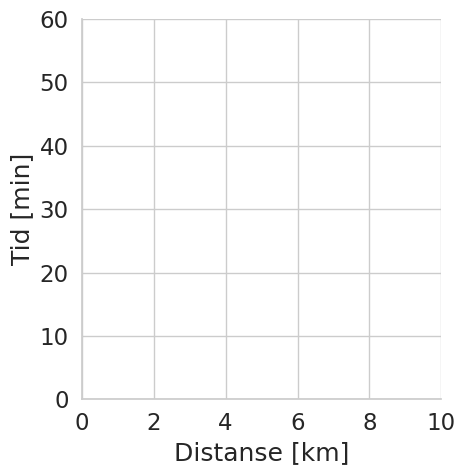

In [15]:
# Plotte observasjoner og regresjonslinje
sns.lmplot(x = 'Distance', y = 'Calories', data = dfny, ci = None)
plt.xlim(0,10); plt.ylim(0,60)  
plt.ylabel('Tid [min]'); plt.xlabel('Distanse [km]')
plt.savefig('plot4.png',bbox_inches='tight') 


## Bonus: illustrasjon av datasett med lavere korrelasjon

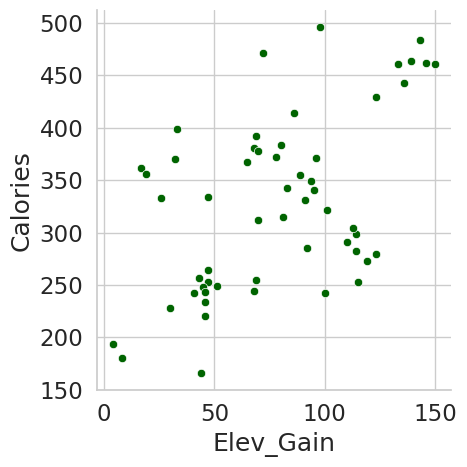

In [16]:
sns.relplot(x='Elev_Gain', y='Calories',data = dfny, color = "darkgreen")